# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
#from scipy.misc.pilutil import imread, imresize
from scipy.misc import imread, imresize
import datetime
import os
from numpy import nanmean

In [2]:
#pip install scipy==1.1.0

In [3]:
import warnings
warnings.filterwarnings('ignore')

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

We set the random seed so that the results don't vary drastically.

np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30)

In [4]:
data_dir = '/home/datasets/Project_data'

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
train_doc = np.random.permutation(open(data_dir + '/train.csv').readlines())
val_doc = np.random.permutation(open(data_dir + '/val.csv').readlines())
batch_size = 40 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [6]:
x = 30 # No. of frames images
#y = 120 # Width of the image
#z = 120 # height

# parameterize the width and height to test with different sizes
def generator(source_path, folder_list, batch_size, width=120, height=120):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0,x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size# calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, x, width, height, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    resized_image = imresize(image,(width, height)) ##default resample=1 or 'P' which indicates PIL.Image.NEAREST
                    resized_image = resized_image/255
                    
                
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size * num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x, width, height, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized_image = imresize(image,(width, height)) ##default resample=1 or 'P' which indicates PIL.Image.NEAREST
                    resized_image = resized_image/255 #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [7]:
curr_dt_time = datetime.datetime.now()
train_path = data_dir + '/train'
val_path = data_dir + '/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 15


#### Import libraries and define model-checkpoint

In [8]:
# Import all the necessary libraries to train model
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
#from keras import optimizers #Code provided by upgrad does not work
from keras import optimizers

In [11]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# Note change the parameter to False, else disk would run out of space.

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

#### Define model architectures to reuse later with different epoc, batch sizes and train model with different image sizes

In [25]:
class model_architecture:
    # initialize default parameter
    num_epochs = 25
    batch_size = 40
    image_width_height = 120
    
    #defining constructor  
    def __init__(self, num_epochs = 15, batch_size = 40, image_width_height = 120):  
        self.num_epochs = num_epochs  
        self.batch_size = batch_size 
        self.image_width_height = image_width_height
        
    def define_architecture_1(self):
        model_arch_1 = Sequential()       
        model_arch_1.add(Conv3D(8,kernel_size=(3,3,3),input_shape=(30, self.image_width_height, self.image_width_height, 3),padding='same'))
        model_arch_1.add(BatchNormalization())
        model_arch_1.add(Activation('relu'))

        model_arch_1.add(Conv3D(16, (3, 3, 3), activation='relu', padding='same')) 
        model_arch_1.add(BatchNormalization())
        model_arch_1.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model_arch_1.add(Conv3D(32, (2, 2, 2), activation='relu', padding='same')) 
        model_arch_1.add(BatchNormalization())
        model_arch_1.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model_arch_1.add(Conv3D(64, (2, 2, 2), activation='relu', padding='same')) 
        model_arch_1.add(BatchNormalization())
        model_arch_1.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model_arch_1.add(Conv3D(128, (2, 2, 2), activation='relu', padding='same')) 
        model_arch_1.add(BatchNormalization())
        model_arch_1.add(MaxPooling3D(pool_size=(2, 2, 2)))      

        # Flatten layer 
        model_arch_1.add(Flatten())
        model_arch_1.add(Dense(1000, activation='relu'))
        model_arch_1.add(Dropout(0.5))

        model_arch_1.add(Dense(500, activation='relu'))
        model_arch_1.add(Dropout(0.5))

        #Softmax layer
        model_arch_1.add(Dense(5, activation='softmax'))

        optimiser = tf.keras.optimizers.Adam() #write your optimizer
        model_arch_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (model_arch_1.summary())

        self.model_arch = model_arch_1
        
    # different variant of architecture 1, with dropouts at more dense layer   
    def define_architecture_2(self):
        model_arch_2 = Sequential()       
        model_arch_2.add(Conv3D(8,kernel_size=(3,3,3),input_shape=(30, self.image_width_height, self.image_width_height, 3),padding='same'))
        model_arch_2.add(BatchNormalization())
        model_arch_2.add(Activation('relu'))

        model_arch_2.add(Conv3D(16, (3, 3, 3), activation='relu', padding='same')) 
        model_arch_2.add(BatchNormalization())
        model_arch_2.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model_arch_2.add(Conv3D(32, (2, 2, 2), activation='relu', padding='same')) 
        model_arch_2.add(BatchNormalization())
        model_arch_2.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model_arch_2.add(Dropout(0.25))

        model_arch_2.add(Conv3D(64, (2, 2, 2), activation='relu', padding='same')) 
        model_arch_2.add(BatchNormalization())
        model_arch_2.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model_arch_2.add(Dropout(0.25))

        model_arch_2.add(Conv3D(128, (2, 2, 2), activation='relu', padding='same')) 
        model_arch_2.add(BatchNormalization())
        model_arch_2.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model_arch_2.add(Dropout(0.25))

        # Flatten layer 
        model_arch_2.add(Flatten())
        model_arch_2.add(Dense(1000, activation='relu'))
        model_arch_2.add(Dropout(0.5))

        model_arch_2.add(Dense(500, activation='relu'))
        model_arch_2.add(Dropout(0.5))

        #Softmax layer
        model_arch_2.add(Dense(5, activation='softmax'))

        optimiser = tf.keras.optimizers.Adam() #write your optimizer
        model_arch_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (model_arch_2.summary())

        self.model_arch = model_arch_2
    
    #architecture with different layer and drop-out at dense layer with 0.5 & 0.25
    def define_architecture_3(self):
        model_arch_3 = Sequential()       
        model_arch_3.add(Conv3D(16,kernel_size=(3,3,3),input_shape=(30, self.image_width_height, self.image_width_height, 3),padding='same'))
        model_arch_3.add(BatchNormalization())
        model_arch_3.add(Activation('relu'))

        model_arch_3.add(Conv3D(32, (2, 2, 2), activation='relu', padding='same')) 
        model_arch_3.add(BatchNormalization())
        model_arch_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model_arch_3.add(Conv3D(64, (2, 2, 2), activation='relu', padding='same')) 
        model_arch_3.add(BatchNormalization())
        model_arch_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model_arch_3.add(Conv3D(128, (2, 2, 2), activation='relu', padding='same')) 
        model_arch_3.add(BatchNormalization())
        model_arch_3.add(MaxPooling3D(pool_size=(2, 2, 2)))      

        # Flatten layer 
        model_arch_3.add(Flatten())
        model_arch_3.add(Dense(512, activation='relu'))
        model_arch_3.add(Dropout(0.5))

        model_arch_3.add(Dense(256, activation='relu'))
        model_arch_3.add(Dropout(0.25))

        #Softmax layer
        model_arch_3.add(Dense(5, activation='softmax'))

        optimiser = tf.keras.optimizers.Adam() #write your optimizer
        model_arch_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (model_arch_3.summary())

        self.model_arch = model_arch_3

    
    def cal_validation_steps_per_epoch(self):
        if (num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (num_train_sequences//self.batch_size) + 1

        if (num_val_sequences%batch_size) == 0:
            validation_steps = int(num_val_sequences/self.batch_size)
        else:
            validation_steps = (num_val_sequences//self.batch_size) + 1

        return steps_per_epoch, validation_steps

    def plot(self, history):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
        axes[0].plot(history.history['loss'])   
        axes[0].plot(history.history['val_loss'])
        axes[0].grid()
        axes[0].legend(['loss','val_loss'])
        axes[1].plot(history.history['categorical_accuracy'])   
        axes[1].plot(history.history['val_categorical_accuracy'])
        axes[1].grid()
        axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    
    def execute(self):
        # Now that you have defined the model in define_architecture_1, the next step is to `compile` the model. 
        # When you print the `summary` of the model, you'll see the total number of parameters you have to train.
        train_generator = generator(train_path, train_doc, self.batch_size, self.image_width_height, self.image_width_height)
        val_generator = generator(val_path, val_doc, self.batch_size, self.image_width_height, self.image_width_height)

        #The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
        steps_per_epoch, validation_steps = self.cal_validation_steps_per_epoch()

        history = self.model_arch.fit_generator(train_generator, steps_per_epoch = steps_per_epoch, epochs = self.num_epochs, verbose=1, 
                        callbacks = callbacks_list, validation_data = val_generator, 
                        validation_steps = validation_steps, class_weight=None, workers=1, initial_epoch=0)
        self.plot(history)
        
        return history

#### Model-1 input summary
- input image size(120x120)
- epochs: 15
- batch size: 40
    
Run the model with few epochs to see if architecutre is working and validation loss is continuously decreasing. In initial few runs i.e. less number of epochs model should overfit i.e. training accuracy should be high and validation accuracy should be less

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_26 (Conv3D)          (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization_18 (Bat  (None, 30, 120, 120, 8)  32        
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 30, 120, 120, 8)   0         
                                                                 
 conv3d_27 (Conv3D)          (None, 30, 120, 120, 16)  3472      
                                                                 
 batch_normalization_19 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 15, 60, 60, 16)  

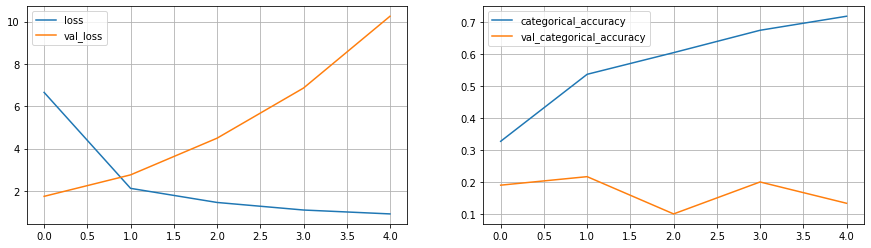

In [26]:
# Define model architecture with num_epoch, batch_size, input image size
model_1 = model_architecture(15, 40, 120)
model_1.define_architecture_1();
print('\n\n=========== Training the model ===========\n\n')
model_1.execute()

#### Model-1 output summary
- Training accuracy: 86.16
- Validation accuracy: 15.00

##### In initial run we see model overfits with less number of epochs. Our theory holds ture and it will be too early to say our model architecture needs change.
Validation loss did not improve and fairly averaged around 6.9410. We should try to train with more number of epochs and various sizes and observe the output.
We should try to experiment with more number of epochs and with different batch size for ex: 30

#### Model-2 input summary (Image-size: 120x120)
- input image size(120x120)
- epochs: 25
- batch size: 40

In [13]:
# Define model architecture with num_epoch, batch_size, input image size
model_2 = model_architecture(25, 40, 120)
model_2.define_architecture_1();
print('\n\n=========== Training the model ===========\n\n')
model_2.execute()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_5 (Conv3D)           (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization_5 (Batc  (None, 30, 120, 120, 8)  32        
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 30, 120, 120, 8)   0         
                                                                 
 conv3d_6 (Conv3D)           (None, 30, 120, 120, 16)  3472      
                                                                 
 batch_normalization_6 (Batc  (None, 30, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 15, 60, 60, 16)  

#### Model-2 output summary
- Training accuracy: 84.78
- Validation accuracy: 30.00

We can observe compared to previous model, after training for more number of epochs model validation accuracy did improve and most importantly validation loss went down to 3.6479. Running for more number of epocs will certainly help. 

Before running for more number of epochs, we should try out with different batch sizes, and image resolution to see the validaton loss and accuracy.

#### Model-3 input summary (batch size:30)
- input image size(120x120)
- epochs: 25
- batch size: 30

In this attempt, try to change the batch size and see how it performed compared to previous model in 25 nb of epocs

In [14]:
# Define model architecture with num_epoch, batch_size, input image size
model_3 = model_architecture(25, 30, 120)
model_3.define_architecture_1();
print('\n\n=========== Training the model ===========\n\n')
model_3.execute()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_10 (Conv3D)          (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization_10 (Bat  (None, 30, 120, 120, 8)  32        
 chNormalization)                                                
                                                                 
 activation_2 (Activation)   (None, 30, 120, 120, 8)   0         
                                                                 
 conv3d_11 (Conv3D)          (None, 30, 120, 120, 16)  3472      
                                                                 
 batch_normalization_11 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 15, 60, 60, 16)  

#### Model-3 output summary
- Training accuracy: 59.42
- Validation accuracy: 55.00
    
##### We can observe that training with batch size of 30 did improve the validation loss and validation accuracy, but training accuracy went down.

#### Model-4 input summary (Image size 150x150)

- input image size(150x150)
- epochs: 25
- batch size: 30

In this attempt, try to change the image width/height size and see how it performed compared to previous model in 25 nb of epocs

In [15]:
# Define model architecture with num_epoch, batch_size, input image size
model_4 = model_architecture(25, 40, 150)
model_4.define_architecture_1();
print('\n\n=========== Training the model ===========\n\n')
model_4.execute()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_15 (Conv3D)          (None, 30, 150, 150, 8)   656       
                                                                 
 batch_normalization_15 (Bat  (None, 30, 150, 150, 8)  32        
 chNormalization)                                                
                                                                 
 activation_3 (Activation)   (None, 30, 150, 150, 8)   0         
                                                                 
 conv3d_16 (Conv3D)          (None, 30, 150, 150, 16)  3472      
                                                                 
 batch_normalization_16 (Bat  (None, 30, 150, 150, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 15, 75, 75, 16)  

#### Model-4 output summary
- Training accuracy: 84.08
- Validation accuracy: 61.67
     
We can see with image size 150x150, training with batch size 40 helps to improve the training/validation accuracy compared with 120x120. We should try to train the model for more number of hours and see the output.

#### Model-5 input summary 

- input image size(150x150)
- epochs: 25
- batch size: 30

In this attempt, try to change the image width/height size and see how it performed compared to previous model in 25 nb of epocs

In [18]:
# Define model architecture with num_epoch, batch_size, input image size
model_5 = model_architecture(25, 30, 150)
model_5.define_architecture_1();
print('\n\n=========== Training the model ===========\n\n')
model_5.execute()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 30, 150, 150, 8)   656       
                                                                 
 batch_normalization_20 (Bat  (None, 30, 150, 150, 8)  32        
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 30, 150, 150, 8)   0         
                                                                 
 conv3d_21 (Conv3D)          (None, 30, 150, 150, 16)  3472      
                                                                 
 batch_normalization_21 (Bat  (None, 30, 150, 150, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 15, 75, 75, 16)  

#### Model-5 output summary
- Training accuracy: 55.07
- Validation accuracy: 65.00

We can observe that training the model with less batch size brings down the training accuracy and improves validation loss. Though the validation loss comes down but training with more number of batches will help to train the model.

### By running different models, we can observe that:
- increasing the batch size definitely helps (40 vs 30)
- image size 150x150 with 25 epochs perform better compared to 120x120. It results in better validation loss and training & validation accuracy

We should experiment the model with more number of samples and higer epochs to see the outcome

#### Model-6 input summary (Image size: 120, with more number of samples in a batch size)

- input image size(120x120)
- epochs: 25
- batch size: 50

In this attempt, try to change the image width/height size and see how it performed compared to previous model in 25 nb of epocs

In [20]:
# Define model architecture with num_epoch, batch_size, input image size
model_6 = model_architecture(25, 50, 120)
model_6.define_architecture_1();
print('\n\n=========== Training the model ===========\n\n')
model_6.execute()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_25 (Conv3D)          (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization_25 (Bat  (None, 30, 120, 120, 8)  32        
 chNormalization)                                                
                                                                 
 activation_5 (Activation)   (None, 30, 120, 120, 8)   0         
                                                                 
 conv3d_26 (Conv3D)          (None, 30, 120, 120, 16)  3472      
                                                                 
 batch_normalization_26 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 15, 60, 60, 16)  

#### Model-6 output summary
- Training accuracy: 72.43
- Validation accuracy: 38.00

We can observe that training the model with more number of batch sizes brings down the validation loss and improved the validation accuracy. But the training accuracy went down. Later we try to run with more number of epocs to see the behavior.

#### Model-7 input summary (Image size: 150, batch size = 50)

- input image size(150x150)
- epochs: 25
- batch size: 50

##### With higher number of batches, we can notice OOM error. With further resource optimization and increased processing power model can be trained and behavior can be observed.

In [22]:
# Define model architecture with num_epoch, batch_size, input image size
model_7 = model_architecture(25, 50, 150)
model_7.define_architecture_1();
print('\n\n=========== Training the model ===========\n\n')
model_7.execute()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_30 (Conv3D)          (None, 30, 150, 150, 8)   656       
                                                                 
 batch_normalization_30 (Bat  (None, 30, 150, 150, 8)  32        
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 30, 150, 150, 8)   0         
                                                                 
 conv3d_31 (Conv3D)          (None, 30, 150, 150, 16)  3472      
                                                                 
 batch_normalization_31 (Bat  (None, 30, 150, 150, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 15, 75, 75, 16)  

2022-05-07 06:22:31.331946: W tensorflow/core/common_runtime/bfc_allocator.cc:463] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.01GiB (rounded to 2160000000)requested by op gradient_tape/sequential_6/max_pooling3d_24/MaxPool3D/MaxPool3DGrad
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-05-07 06:22:31.332115: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2022-05-07 06:22:31.332159: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 474, Chunks in use: 473. 118.5KiB allocated for chunks. 118.2KiB in use in bin. 37.4KiB client-requested in use in bin.
2022-05-07 06:22:31.332186: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 78, Chunks in use: 77. 39.8KiB allocated for chunks. 39.0KiB in use in bin. 38.5K

ResourceExhaustedError:  OOM when allocating tensor with shape[50,16,30,150,150] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/sequential_6/max_pooling3d_24/MaxPool3D/MaxPool3DGrad
 (defined at /usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/optimizer_v2.py:464)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_30807]

Errors may have originated from an input operation.
Input Source operations connected to node gradient_tape/sequential_6/max_pooling3d_24/MaxPool3D/MaxPool3DGrad:
In[0] sequential_6/batch_normalization_31/FusedBatchNormV3 (defined at /usr/local/lib/python3.8/dist-packages/keras/layers/normalization/batch_normalization.py:589)	
In[1] sequential_6/max_pooling3d_24/MaxPool3D (defined at /usr/local/lib/python3.8/dist-packages/keras/layers/pooling.py:699)	
In[2] gradient_tape/sequential_6/conv3d_32/Conv3D/Conv3DBackpropInputV2:

Operation defined at: (most recent call last)
>>>   File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 450, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell
>>>     await result
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 652, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 359, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/zmqshell.py", line 532, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2914, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3457, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/tmp/ipykernel_1959/1044347880.py", line 5, in <module>
>>>     model_7.execute()
>>> 
>>>   File "/tmp/ipykernel_1959/2649880545.py", line 74, in execute
>>>     self.model_arch.fit_generator(train_generator, steps_per_epoch = steps_per_epoch, epochs = self.num_epochs, verbose=1,
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 2016, in fit_generator
>>>     return self.fit(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 816, in train_step
>>>     self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/optimizer_v2.py", line 530, in minimize
>>>     grads_and_vars = self._compute_gradients(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/optimizer_v2.py", line 583, in _compute_gradients
>>>     grads_and_vars = self._get_gradients(tape, loss, var_list, grad_loss)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/optimizer_v2.py", line 464, in _get_gradients
>>>     grads = tape.gradient(loss, var_list, grad_loss)
>>> 

### From our previous runs we noticed that image with more number of epochs and increased batch size performs better. Try to execute the previous models with more number of batches


#### Model-8 input summary (Image size: 120, batch size = 40)

- input image size(120x120)
- epochs: 50
- batch size: 40

In [24]:
# Define model architecture with num_epoch, batch_size, input image size
model_8 = model_architecture(50, 40, 120)
model_8.define_architecture_1();
print('\n\n=========== Training the model ===========\n\n')
model_8.execute()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_35 (Conv3D)          (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization_35 (Bat  (None, 30, 120, 120, 8)  32        
 chNormalization)                                                
                                                                 
 activation_7 (Activation)   (None, 30, 120, 120, 8)   0         
                                                                 
 conv3d_36 (Conv3D)          (None, 30, 120, 120, 16)  3472      
                                                                 
 batch_normalization_36 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_28 (MaxPoolin  (None, 15, 60, 60, 16)  

#### Model-8 output summary
- Training accuracy:  86.16
- Validation accuracy: 88.33

We can observe that training the model with more number of batch sizes brings down the validation loss and improved the validation accuracy. But the training loss went down. Later we try to run with more number of epocs to see the behavior.

#### Model-9 input summary (Image size: 150, batch size = 40)

- input image size(150x150)
- epochs: 50
- batch size: 40

In [27]:
# Define model architecture with num_epoch, batch_size, input image size
model_9 = model_architecture(50, 40, 150)
model_9.define_architecture_1();
print('\n\n=========== Training the model ===========\n\n')
model_9.execute()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_40 (Conv3D)          (None, 30, 150, 150, 8)   656       
                                                                 
 batch_normalization_40 (Bat  (None, 30, 150, 150, 8)  32        
 chNormalization)                                                
                                                                 
 activation_8 (Activation)   (None, 30, 150, 150, 8)   0         
                                                                 
 conv3d_41 (Conv3D)          (None, 30, 150, 150, 16)  3472      
                                                                 
 batch_normalization_41 (Bat  (None, 30, 150, 150, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_32 (MaxPoolin  (None, 15, 75, 75, 16)  

#### Model-9 output summary
- Training accuracy: 81.31
- Validation accuracy: 61.67  

We can observe that training the model with Image size (150x150) with higher number of batches brings down the accuracy and performed poorly compared to image size of 120x120. 

##### Going further, model with different layer of archtectures can be trained with 120x120 image sizes

### Trying different architecture(2)

#### Model-10 (Image-size 120x120)
- num_epoch: 25
- batch_size: 40
- image_size: 120x120

##### Model training with less number of epochs

In [13]:
# Define model architecture with num_epoch, batch_size, input image size
model_10 = model_architecture(25, 40, 120)
model_10.define_architecture_2();
print('\n\n=========== Training the model ===========\n\n')
model_10.execute()

2022-05-07 14:40:59.130379: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-05-07 14:40:59.130451: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1c:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization (BatchN  (None, 30, 120, 120, 8)  32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 120, 120, 8)   0         
                                                                 
 conv3d_1 (Conv3D)           (None, 30, 120, 120, 16)  3472      
                                                                 
 batch_normalization_1 (Batc  (None, 30, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 60, 60, 16)   0

2022-05-07 14:41:06.102871: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


17/17 [==============================] - ETA: 0s - loss: 10.7104 - categorical_accuracy: 0.2504Source path =  /home/datasets/Project_data/val ; batch size = 40

Epoch 00001: val_loss improved from inf to 2.17877, saving model to model_init_2022-05-0714_40_18.671989/model-00001-10.71037-0.25038-2.17877-0.21000.h5
17/17 [==============================] - 92s 5s/step - loss: 10.7104 - categorical_accuracy: 0.2504 - val_loss: 2.1788 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/25
17/17 [==============================] - ETA: 0s - loss: 2.5576 - categorical_accuracy: 0.4092
Epoch 00002: val_loss did not improve from 2.17877
17/17 [==============================] - 52s 3s/step - loss: 2.5576 - categorical_accuracy: 0.4092 - val_loss: 4.2571 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/25
17/17 [==============================] - ETA: 0s - loss: 1.9002 - categorical_accuracy: 0.4060
Epoch 00003: val_loss improved from 2.17877 to 1.91464, saving model to model_init_2022-05

#### Model-10 output summary
- Training accuracy: 75.43
- Validation accuracy: 26.67

Deep learning models are evaluated should be based on the loss. Though the training loss is very low but the validation loss is quite high compared to model 1.
Model architecture 1 seems to be better compared to architecture 2.

### Trying different architecture(3)

#### Model-10 (Image-size 120x120)
- num_epoch: 25
- batch_size: 40
- image_size: 120x120

##### Model training with less number of epochs

In [22]:
# Define model architecture with num_epoch, batch_size, input image size
model_11 = model_architecture(25, 40, 120)
model_11.define_architecture_3();
print('\n\n=========== Training the model ===========\n\n')
model_11.execute()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_13 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 conv3d_14 (Conv3D)          (None, 30, 120, 120, 16)  6928      
                                                                 
 batch_normalization_9 (Batc  (None, 30, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 15, 60, 60, 16)   0         
 3D)                                                             
                                                                 
 dropout_11 (Dropout)        (None, 15, 60, 60, 16)    0         
                                                                 
 conv3d_15 (Conv3D)          (None, 15, 60, 60, 32)   

#### Model-11 output summary
- Training accuracy: 55.36
- Validation accuracy: 26.67

Compared to architecture-1, architecture-3 seems to perform very bad with same number of epochs=25, batch_size=40 and image size of 120. Validation loss seems to be high compared to model-1.